# EVEREST and RR Lyrae

One of the known issues with the EVEREST pipeline is that it tends to overfit
stars with high frequency, high amplitude variability, such as RR Lyrae. This
is because of issues with the optimization of the Gaussian Process kernel. In
this notebook, we show an example of a K2 RR Lyrae star, discuss how to determine
whether it has been overfitted, and provide a way to properly de-trend it with
some manual hacks.

Note that most users will not want to go through the hassle of manually de-trending
RR Lyrae light curves. We recommend that users simply check whether the amplitude
of the RR Lyrae signal appears diminished relative to that in the raw light curve.
If it's not, chances are the EVEREST de-trending worked and you're good to go. But
if the amplitude looks visibly diminished, we recommend that users take a look at the
K2SC version of the light curve (if available), as that pipeline has a much more 
robust GP optimization scheme.

Note that K2SC light curves are currently available only for a few campaigns. If a K2SC
RR Lyrae light curve is not available (and the EVEREST one doesn't look great), you
can either follow the tips in this notebook or just do science on the raw light curve.
For many RR Lyrae, the astrophysical variability is much stronger than the instrumental
noise, so de-trending isn't that important anyways.

One final word before we begin: you can find a list of 100 RR Lyrae EPIC IDs to
play with [here](https://rodluger.github.io/everest/_downloads/rrlyrae.tsv). Just type

```bash
everest 210868876 -r2
```

in a terminal to display both the raw () and de-trended (v2) light curves for a particular target.

In [69]:
# Standard imports
import everest
import matplotlib.pyplot as pl
import numpy as np
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [122]:
# Let's load the EVEREST light curve for an RR Lyrae
# whose de-trending was messed up.
EPIC = 205495245
star = everest.Everest(EPIC)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 205495245.


INFO  [everest.user.plot()]: Plotting the light curve...


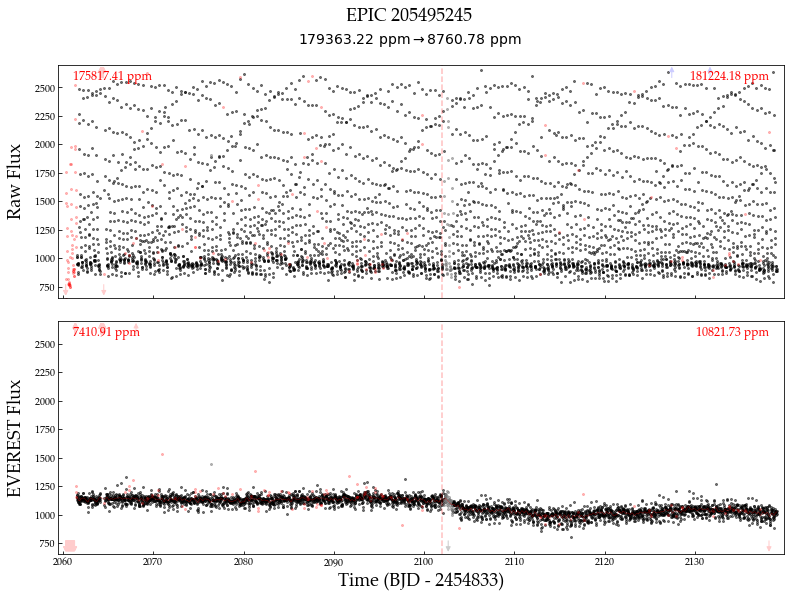

In [123]:
# Let's take a look at it...
star.plot()

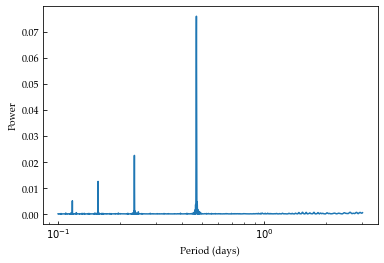

In [124]:
# That looks terrible! Notice how the amplitude of variability has decreased by over an
# order of magnitude from the raw flux (top) to the de-trended flux (bottom). RR Lyrae
# typically have variability amplitudes of 0.5 - 1 mag, so for most reasonably bright
# stars it dominates over instrumental systematics. The variability in the raw light curve
# is therefore *real*, and EVEREST is removing it by mistake.
#
# Let's try to figure out the period of this variable using a Lomb-Scargle periodogram.
#
from scipy.signal import lombscargle
pmax = 3.
pmin = 0.1
N = 10000
f = np.linspace(2 * np.pi / pmax, 2 * np.pi / pmin, N)
pgram = lombscargle(star.apply_mask(star.time), star.apply_mask(star.fraw), f, normalize=True)
pl.plot(2 * np.pi / f, pgram)
pl.xscale('log');
pl.xlabel('Period (days)');
pl.ylabel('Power');

In [125]:
# The largest peak corresponds to a period of...
period = (2 * np.pi / f[np.argmax(pgram)])
print("Period: %s days" % period)

Period: 0.468937593797 days


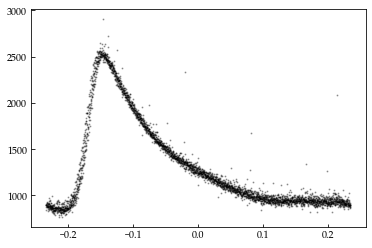

In [126]:
# Let's plot the phase-folded *raw* light curve:
time = (star.apply_mask(star.time) - period / 2.) % period - period / 2.
pl.plot(time, star.apply_mask(star.fraw), 'k.', alpha=0.3, ms=2);

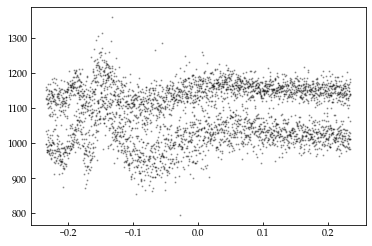

In [127]:
# Beautiful! Now what does the EVEREST phase-folded light curve look like?
pl.plot(time, star.apply_mask(star.flux), 'k.', alpha=0.3, ms=2);

In [128]:
# Gross.
#
# Typically, this happens because the GP was not optimized properly. Let's look at 
# what the optimizer settled on for the white noise amplitude, the red noise amplitude,
# and more importantly, the red noise timescale:
star.kernel_params

array([    47.09999722,  31737.23789013,    100.        ])

In [183]:
# Aha! The kernel used by EVEREST is a combination of a white noise kernel and a 
# Matern-3/2 (red) kernel. The first number (47.) is the amplitude of the white
# kernel and should be close to the Poisson photon error -- the number looks reasonable.
# But the second number (31737.) is the amplitude of the red noise kernel, and as we
# will see below, it's too low. The third number (100.) is the timescale of the
# kernel, which is *way* too high. Let's set it to the correct period:
star.kernel_params[2] = 0.46893759379689848

In [ ]:
# Now, the amplitude of the red noise kernel is also wrong. Typically, for RR Lyrae
# this should be set to something very large to capture the extreme variability.
# The following took a few minutes of manual tweaking by guessing an amplitude,
# then computing the model and seeing if EVEREST was still overfitting.
star.kernel_params[1] = 2e6

In [189]:
# That's pretty much all we *need* to do, but there are two other steps that will
# also help with the de-trending. First, let's take a look at the regularization matrix
# amplitude, log(lambda):
np.log10(star.lam)

array([[ 4.5,  7.5,  9. ],
       [ 4.5,  7.5,  6. ]])

In [190]:
# There's one value of lambda per PLD order, per light curve chunk. There are three
# PLD orders and two light curve chunks, so 6 values total. Typically, the most important
# of these are the first order PLD regularization terms, which are both set to 4.5.
# This is quite low. Typical values should be on the order of 8 or 9. Such a low value
# means the PLD model will be ineffective at removing instrumental noise. Let's
# bump it up to log(lam) = 9:
star.lam[0][0] = 10 ** 9

In [191]:
# Finally, we could also bump up lambda for the second light curve chunk, but it's
# best to get rid of the light curve subdivision entirely. Notice that because of the
# high frequency variability, EVEREST didn't do a great job at "mending" the two chunks
# back together (see the de-trended light curve plot above, and how there's a "step"
# following the breakpoint at t ~ 2100 days). Let's remove the breakpoint. We still need
# a breakpoint at the very end of the light curve (just because of how EVEREST is set up),
# so we simply do
star.breakpoints = [star.breakpoints[-1]]

INFO  [everest.basecamp.compute()]: Computing the model...
INFO  [everest.user.plot()]: Plotting the light curve...


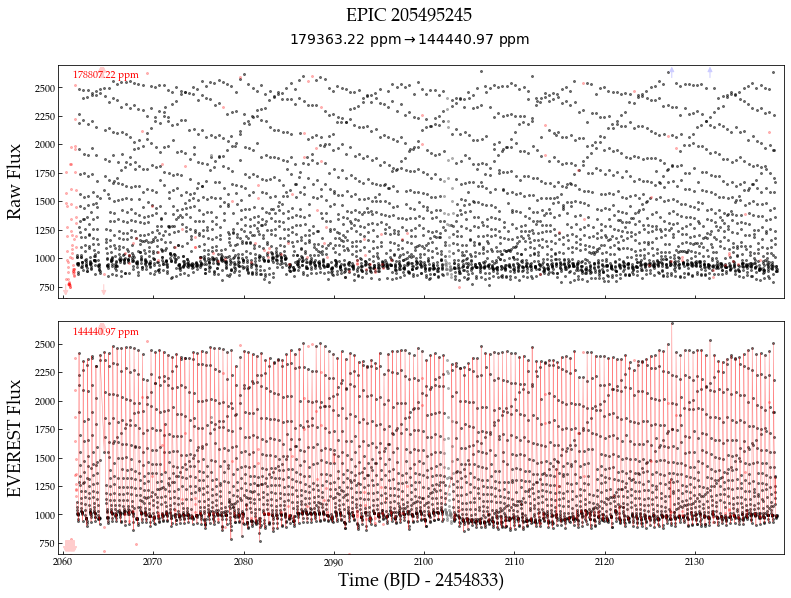

In [185]:
# Now we are ready to re-compute the PLD model and plot the result!
star.compute()
star.plot()

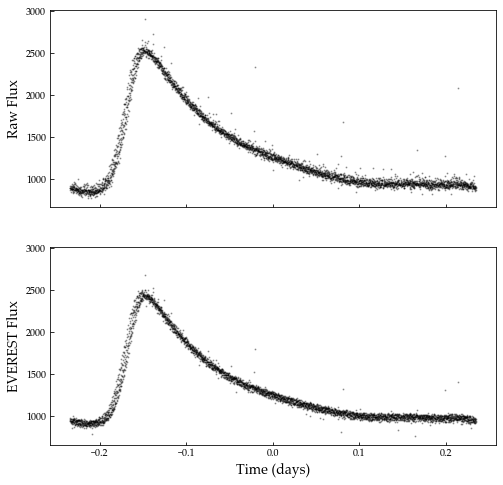

In [186]:
# Voila! No more horrible overfitting. And the CDPP still looks better than that of the
# raw light curve.
#
# As a final step, let's plot the phase-folded EVEREST light curve next to the raw light curve
# to see how we really did:
time = (star.apply_mask(star.time) - period / 2.) % period - period / 2.
fig, ax = pl.subplots(2, figsize=(8,8), sharex=True, sharey=True)
ax[0].plot(time, star.apply_mask(star.fraw), 'k.', alpha=0.3, ms=2);
ax[0].set_ylabel('Raw Flux', fontsize=14);
ax[1].plot(time, star.apply_mask(star.flux), 'k.', alpha=0.3, ms=2);
ax[1].set_ylabel('EVEREST Flux', fontsize=14);
ax[1].set_xlabel('Time (days)', fontsize=14);

In [ ]:
# Phew! The de-trended light curve looks great. There are fewer outliers,
# and the CDPP is *slightly* improved. Note, importantly, that there may
# be a tiny bit of overfitting -- the peak amplitude in the EVEREST light
# curve seems to be *slightly* lower. But this isn't bad for manual
# tweaking!